# Study of a scaling scheme for resolution of (regularized) semi-discrete OT

In [8]:
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from scipy.integrate import quad

### Definition of source and target:
* $\rho$ is the Lebesgue measure on the unit segment $[0, 1]$
* $\mu = \frac{1}{10} \sum_{i=1}^{10} \delta_{y_i}$ is a uniform discrete measure with support of size $10$ included in $[0, 1]$. We denote $N=10$.

Y = [2.05808361 2.15599452 2.15601864 2.37454012 2.59865848 2.60111501
 2.70807258 2.73199394 2.86617615 2.95071431]


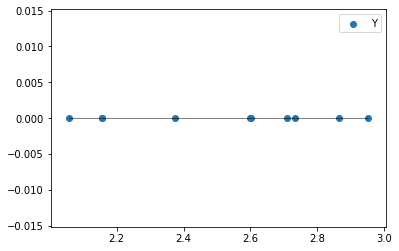

In [9]:
n_target = 10
b = np.ones(n_target)/n_target
rng = np.random.RandomState(42)
Y_target = np.sort(2 + rng.rand(n_target))
print("Y =", Y_target)

plt.scatter(Y_target, np.zeros(n_target), label="Y")
plt.plot(Y_target, np.zeros(n_target), c="k", lw=0.5)
plt.legend()
plt.savefig('support-mu.pdf')  
plt.show()

### Solve unregularized OT
We find $\psi^0$ recursively using the following relation: for $k \in \{1, \dots, N-1\}$ and $x_k = \frac{k}{N}$,
$$ x_k y_k - \psi^0_k = x_k y_{k+1} - \psi^0_{k+1}. $$
Then normalize so that $\langle \psi^0, \mathbb{1}_N \rangle = 0$.

In [10]:
psi_0 = np.zeros(n_target)
for k in range(n_target-1):
    psi_0[k+1] = (k+1)/n_target*(Y_target[k+1]-Y_target[k]) + psi_0[k]
    
def T(x):
    return np.argmax(x*Y_target - psi_0)

xx = np.linspace(0, 1, 15)
for x in xx:
    print("T({}) = y_{}".format(x, T(x)+1))
    
psi_0 = psi_0 - (1/n_target)*np.sum(psi_0)

print("\npsi_0 =", psi_0)

print("\n<psi_0, 1_N> =", np.sum(psi_0))

T(0.0) = y_1
T(0.07142857142857142) = y_1
T(0.14285714285714285) = y_2
T(0.21428571428571427) = y_3
T(0.2857142857142857) = y_3
T(0.3571428571428571) = y_4
T(0.42857142857142855) = y_5
T(0.5) = y_5
T(0.5714285714285714) = y_6
T(0.6428571428571428) = y_7
T(0.7142857142857142) = y_8
T(0.7857142857142857) = y_8
T(0.8571428571428571) = y_9
T(0.9285714285714285) = y_10
T(1.0) = y_10

psi_0 = [-0.16887878 -0.15908769 -0.15908287 -0.09352642 -0.00387908 -0.00265081
  0.06152373  0.07826868  0.18561445  0.26169879]

<psi_0, 1_N> = -5.551115123125783e-17


### Solve regularized OT for a given regularization

Here we solve the following optimization problem:

$$ (1) \qquad \min_{\psi \in \mathbb{R}^N} F^\epsilon(\psi), $$
where $$F^\epsilon(\psi) = \int_0^1 \epsilon \log \left( \sum_{i=1}^N e^{\frac{xy_i - \psi_i}{\epsilon}} \right) dx + \langle \psi, \mathbb{1}_N \rangle + \epsilon = \int_0^1 f^\epsilon(x, \psi) dx + \langle \psi, \mathbb{1}_N \rangle + \epsilon.$$
The function $F^\epsilon$ is convex on $\mathbb{R}^N$ and stricly convex on $(\mathbb{1}_N)^\perp$. We use the gradient descent algorithm to solve $(1)$. To do so, notice that the gradient of $F^\epsilon$ is obtained using the formulas:
$$ \frac{ \partial F^\epsilon}{\partial \psi_i} (\psi) = \mu - \int_0^1 \frac{ e^{\frac{xy_i - \psi_i}{\epsilon}} }{ \sum_{j=1}^N e^{\frac{xy_j - \psi_j}{\epsilon}} } dx.$$

Both the cost function $F^\epsilon$ and the gradient $\nabla F^\epsilon = (\frac{ \partial F^\epsilon}{\partial \psi_i})_{i=1, \dots, N}$ are computed using ```scipy.integrate.quad```.

In [11]:
def h(x, j, psi, eps, b, Y_target):
    r = (x*Y_target - psi)/eps
    r -= np.max(r)
    pi = np.exp(r)/np.sum(np.exp(r))
    return (b - pi).flatten()[j]

def f(x, psi, eps, b, Y_target):
    r = x*Y_target - psi
    max_r = np.max(r)
    r -= max_r
    return max_r + eps*np.log(np.sum(np.exp(r/eps)))

def get_cost(psi, eps, b, Y_target):
    A = quad(f, 0, 1, args=(psi, eps, b, Y_target))[0]
    B = np.sum(b*psi)
    return A + B + eps

def gradient(psi, eps, b, Y_target):
    grad = np.zeros(len(Y_target))
    for j in range(len(Y_target)):
        grad[j] = quad(h, 0, 1, args=(j, psi, eps, b, Y_target))[0]
    return grad
        
def gradient_descent(psi_init, eps, b, Y_target, lr, num_iter, return_log_psi=False):
    print("eps =", eps)
    n_target = len(Y_target)
    psi = psi_init
    log_cost = []
    if return_log_psi: log_psi = np.zeros((n_target, num_iter))
    for k in tqdm(range(num_iter)):
        psi -= lr*gradient(psi, eps, b, Y_target)
        if return_log_psi: log_psi[:, k] = psi
        log_cost.append(get_cost(psi, eps, b, Y_target))
    if return_log_psi:
        return psi, log_cost, log_psi
    else:
        return psi, log_cost

def plot_cost(num_iter, log_cost):
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(num_iter), log_cost)
    plt.xlabel("Iterations")
    plt.ylabel("Cost")
    plt.subplot(1, 2, 2)
    plt.loglog(np.arange(num_iter), log_cost)    
    plt.xlabel("Iterations")
    plt.ylabel("Cost")
    plt.show()
    return None

We use the defined algorithms to solve the regularized OT problem with $\epsilon=10^{-4}$. Note that we choose the learning rates & number iterations in order to ensure the most rapid convergence.

eps = 0.0001


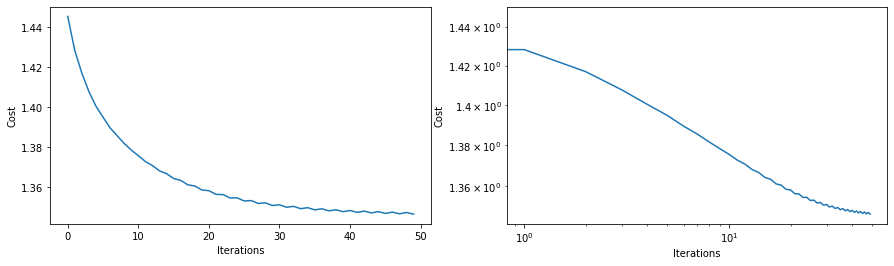

psi^\eps =
[-0.15017615 -0.13790981 -0.14218621 -0.08759218 -0.00641509 -0.00817359
  0.05360417  0.06508149  0.16968324  0.24408413]
psi^0 =
[-0.16887878 -0.15908769 -0.15908287 -0.09352642 -0.00387908 -0.00265081
  0.06152373  0.07826868  0.18561445  0.26169879]


In [12]:
eps = 1e-4
lr = 5e-2
num_iter = 50
psi_init = np.zeros(n_target)

psi_eps, log_cost = gradient_descent(psi_init, eps, b, Y_target, lr=lr, num_iter=num_iter)
psi_eps = psi_eps - (1/n_target)*np.sum(psi_eps)

plot_cost(num_iter, log_cost)

log_cost_no_scaling = log_cost.copy()

print("psi^\eps =")
print(psi_eps)
print("psi^0 =")
print(psi_0)

Use scaling scheme to solve the same problem. Note that we choose the learning rates for each sub-problem in order to ensure the most rapid convergence in the given number of iterations for the subproblem (here 5).

eps = 1.0


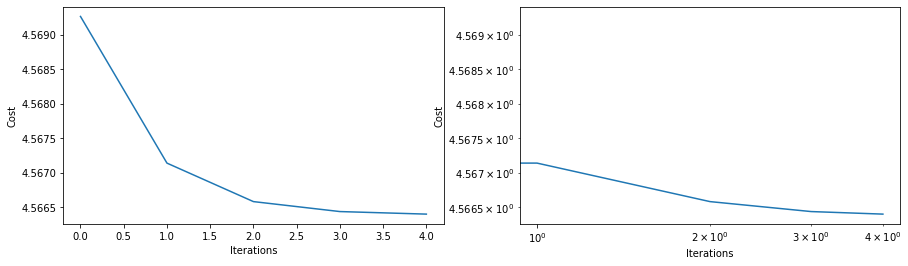

eps = 0.1


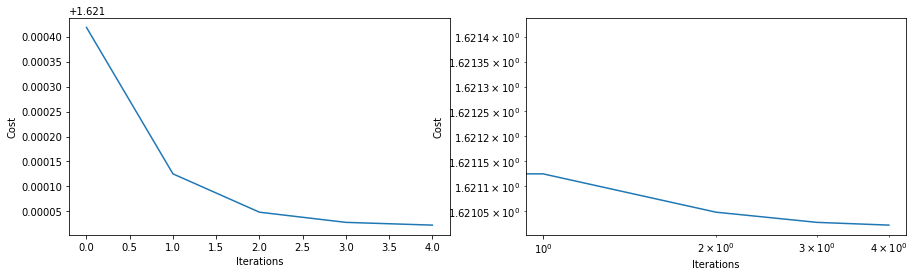

eps = 0.01


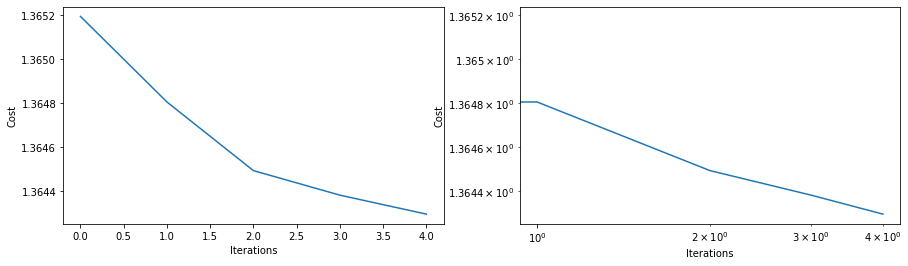

eps = 0.001


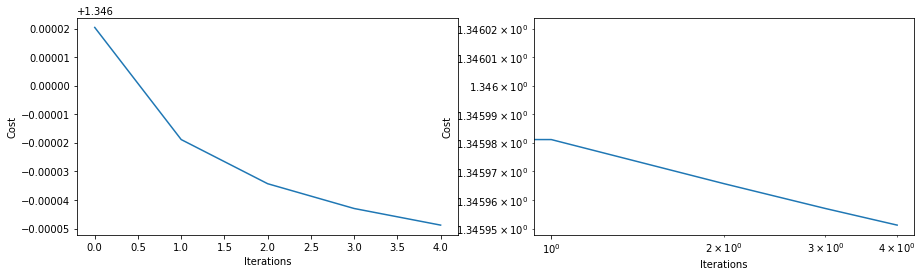

eps = 0.0001


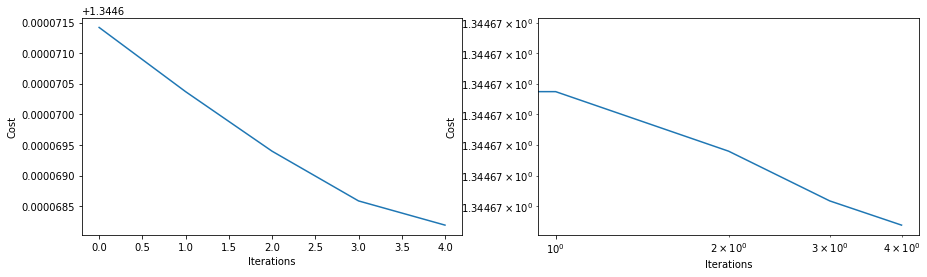

psi^\eps =
[-0.17244178 -0.16213602 -0.16207981 -0.09557405 -0.00217503 -0.00088767
  0.0638717   0.08064188  0.1874565   0.26332428]
psi^0 =
[-0.16887878 -0.15908769 -0.15908287 -0.09352642 -0.00387908 -0.00265081
  0.06152373  0.07826868  0.18561445  0.26169879]


In [13]:
eps = 1e-4
num_scalings = 5
num_iter = 5
eps_schedule = [eps * 10**(i) for i in range(num_scalings)]
lr_schedule = [3e-3, 2e-2, 2e-1, 5e-1, 5e0]
psi_init = np.zeros(n_target)
log_log_costs = []
log_psi = np.zeros((n_target, num_scalings*num_iter))

for i in range(5):#num_scalings):
    cur_eps = eps_schedule[num_scalings-i-1]
    lr = lr_schedule[num_scalings-i-1] #eps**(2/3)
    psi_eps, log_cost, log_psi_eps = gradient_descent(psi_init, cur_eps, b, Y_target, lr=lr, num_iter=num_iter, return_log_psi=True)
    psi_eps = psi_eps - (1/n_target)*np.sum(psi_eps)
    
    plot_cost(num_iter, log_cost)
    
    log_log_costs.append(log_cost)
    log_psi[:, (i*num_iter):((i+1)*num_iter)] = log_psi_eps
    psi_init = psi_eps.copy()
    

print("psi^\eps =")
print(psi_eps)
print("psi^0 =")
print(psi_0)

Plot the cost function of the original problem (i.e. $F^\epsilon(\psi_k)$ for $\epsilon = 10^{-4}$) vs. the number of iterations for the scaling and no scaling schemes:

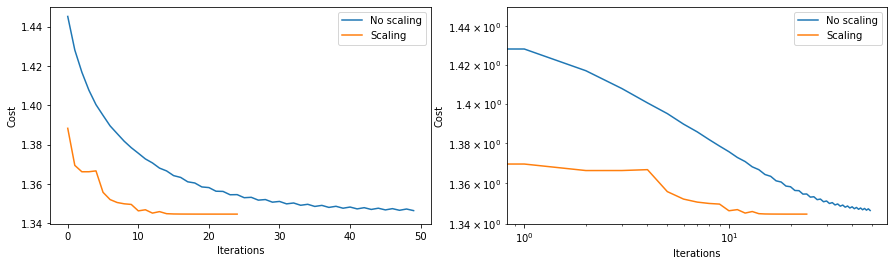

In [14]:
log_cost_scaling = np.array([get_cost(log_psi[:, i], eps, b, Y_target) for i in range(num_scalings*num_iter)])


plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(log_cost_no_scaling, label="No scaling")
plt.plot(log_cost_scaling, label="Scaling")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.legend()

plt.subplot(1, 2, 2)
plt.loglog(log_cost_no_scaling, label="No scaling")    
plt.loglog(log_cost_scaling, label="Scaling")
plt.xlabel("Iterations")
plt.ylabel("Cost")

plt.legend()
plt.savefig('cost-vs-iterations-scaling-and-no-scaling.pdf')  
plt.show()